In [1]:
%load_ext autoreload
%autoreload 2

# Training as a function of the number of patterns

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from wassa.wassa_plots import plot_results_std, plot_SM, plot_colored_raster
from wassa.dataset_generation import sm_generative_model, generate_dataset
from wassa.wassa_utils import performance_as_a_function_of_number_of_motifs

In [3]:
date = '2024_01_24'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
device = 'cuda:1'

In [5]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 255 # number of timesteps for the raster plot (in ms)
    N_samples = 60 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 1 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 16*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = .1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

In [6]:
class training_parameters:
    kernel_size = (dataset_parameters.N_SMs, dataset_parameters.N_pre, dataset_parameters.N_delays)
    loss_type = 'mse'
    N_learnsteps = 1000
    learning_rate = .001
    penalty_type = 'smoothed_orthogonality'
    smoothwind = 40
    lambda_ = .1
    batch_size = None
    output = 'linear' 
    do_bias = True 
    zeros = 'ignore'
    wass_order = 1
    weight_init = None
    if not penalty_type:
        lambda_ = 0
    elif penalty_type[:8] != 'smoothed': 
        smoothwind = 0
    if lambda_ == 0:
        penalty_type = None
    def get_parameters(self):
        name = f'{self.loss_type}_{self.output}_{self.penalty_type}_{self.do_bias}_{self.kernel_size}_{self.N_learnsteps}_{self.learning_rate}_{self.lambda_}_{self.batch_size}_{self.smoothwind}'
        if self.loss_type == 'emd':
            name += f'_{self.zeros}_{self.wass_order}'
        return name

In [7]:
params_mse = training_parameters()
params_emd = training_parameters()
params_emd.loss_type = 'emd'
params_emd.penalty_type = 'cc'
params_emd.lambda_ = 1

In [8]:
N_iter = 20
seeds = torch.arange(0,N_iter)
num_patterns = torch.arange(1,10)
results, num_patterns = performance_as_a_function_of_number_of_motifs(dataset_parameters, params_emd, params_mse, date, num_patterns, N_iter = N_iter, seeds = seeds, device=device)

../results/2024_01_24_performance_as_a_function_of_number_of_motifs_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0.1_1_666_emd_linear_cc_True_(1, 100, 51)_1000_0.001_1_None_40_ignore_1_1_9


/home/antoine/Documents/wassa/wassa/wassa_utils.py:106: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:697.)
  model.decoding_weights.data.div_((torch.linalg.norm(model.decoding_weights.data, ord=2, dim=(1,2), keepdim=True)+1e-14).repeat(1,model.decoding_weights.shape[1],model.decoding_weights.shape[2]))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [2:27:12<00:00, 49.07s/it]


In [55]:
def plot_results_std(ax, results, coefs, xlabel, ylabel, legend, color, do_ylabel, ymax=None, ymin=None, do_legend=False, logplot=False, quantile=False):
     
    mean_, std_ = results.mean(axis=0), results.std(axis=0)
    
    if quantile:
        q5 = results.quantile(.2,axis=0)
        q95 = results.quantile(.8,axis=0)

    if quantile:
        bottom_ = q5
    elif ymin is not None:
        bottom_ = np.maximum(mean_ - std_, ymin*np.ones([len(mean_)]))
    else:
        bottom_ = mean_ - std_
        
    if quantile:
        top_ = q95
    elif ymax is not None:
        top_= np.minimum(mean_ + std_, ymax*np.ones([len(mean_)]))
    else:
        top_ = mean_ + std_

    if logplot:
        ax.semilogx(coefs, mean_, '.',color=color, label=legend)
    else:
        ax.plot(coefs, mean_, 'P',color=color, markeredgecolor='white', markersize=10, label=legend)

    ax.scatter(coefs.unsqueeze(0).repeat(results.shape[0],1),results, color=color,alpha=.2)
    
    ax.fill_between(coefs, bottom_, top_, facecolor=color, edgecolor=None, alpha=.3)

    ax.set_ylim(ymin,ymax)
    
    if xlabel: 
        ax.set_xlabel(xlabel, fontsize=14)
    else: 
        ax.set_xticks([])
    if do_ylabel:
        ax.set_ylabel('similarity value', fontsize=14)
    else: 
        ax.set_yticks([])
    ax.set_title(ylabel, fontsize=16)
    if do_legend: 
        ax.legend(fontsize=12);

    return ax

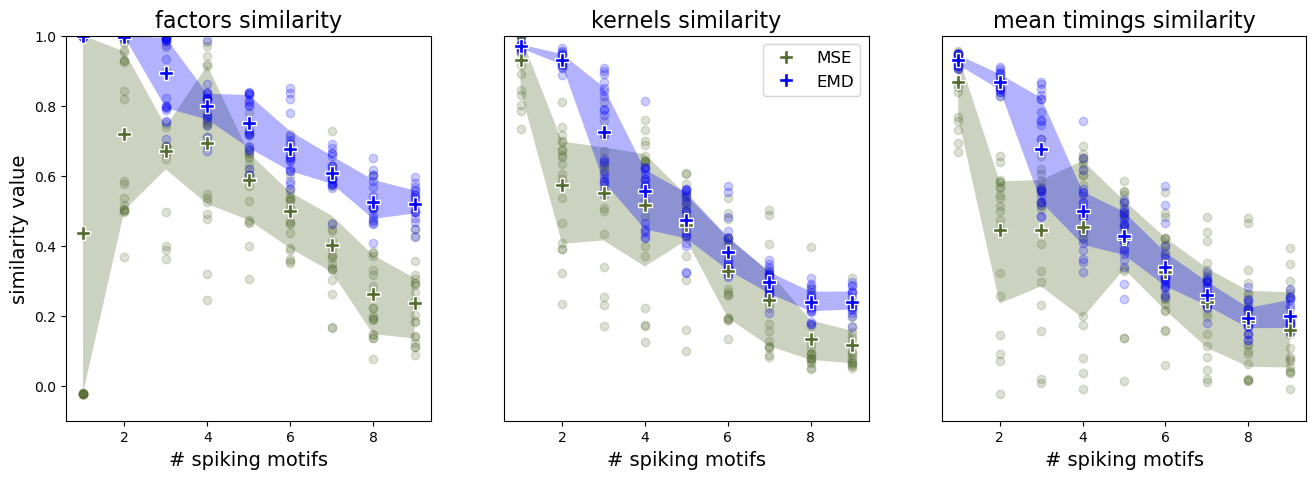

In [56]:
import matplotlib.pyplot as plt

name_metrics = ['factors similarity', 'kernels similarity', 'mean timings similarity']
name_methods = ['MSE', 'EMD']#, 'combined']
colors = ['darkolivegreen','blue','orangered']
xlabel = '# spiking motifs'

results = results.cpu()
fig, ax = plt.subplots(1,3, figsize=(16,5))
for i in range(len(name_metrics)):
    for m in range(len(name_methods)):
        if i==0:
            do_ylabel = True
        else:
            do_ylabel = False
        if i == 0:
            ymin = -.1
        else:
            ymin = 0
        if i == 1:
            do_legend = True
        else:
            do_legend = False
        ax[i] = plot_results_std(ax[i],results[m,:,:,i],num_patterns,xlabel,name_metrics[i],name_methods[m],colors[m],ymax=1,ymin=ymin,do_ylabel=do_ylabel,do_legend=do_legend,quantile=True)

In [57]:
fig.tight_layout()
fig.savefig('../figures/results_motifs.pdf', bbox_inches = 'tight')